In [2]:
import keras.saving
import pandas as pd
import numpy as np
from keras import layers
from keras.models import Model
import matplotlib.pyplot as plt

In [3]:
from data_reader import df, train_df, test_df

# LSTM - Long Short-Term Memory model

## Using one column to predict next value

In [4]:
data = df[['Scaled']].copy()
data['Target'] = df['Scaled'].shift(-1)
data.dropna(inplace=True)

data.head()

,Scaled,Target
Date,,
2002-05-23,0.152597,0.159539
2002-05-24,0.159539,0.154332
2002-05-28,0.154332,0.144335
2002-05-29,0.144335,0.135726
2002-05-30,0.135726,0.133366


In [5]:
backcandles = 10
X = np.array([data[['Scaled']][i-backcandles : i] for i in range(backcandles, len(data))])
y = np.array(data[['Target']][backcandles:])

print(X.shape, y.shape)

(5489, 10, 1) (5489, 1)


In [6]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [7]:
lstm_input = layers.Input(shape=(backcandles, 1), name='lstm_input')
inputs = layers.LSTM(128, name='1st_layer')(lstm_input)
inputs = layers.Dense(1, name='2nd_layer')(inputs)
output = layers.Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1st_layer (LSTM)                │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2nd_layer (Dense)               │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Activation)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(X_train, y_train, batch_size=15, epochs=30, shuffle=True)

Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0139
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 8/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 9/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 10/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 11/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 12/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 13/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 14/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 15/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

In [9]:
y_pred = model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


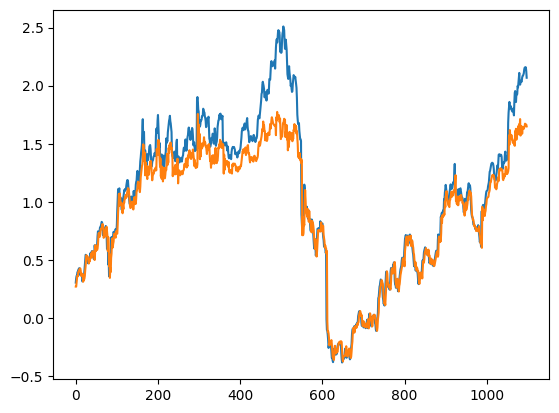

In [10]:
plt.plot(y_test)
plt.plot(y_pred)

In [11]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f'Mean absolute error: {error}')

Mean absolute error: 0.14263091861339128


In [21]:
import keras_tuner as kt

def build_model(hp):
    n_neurons = hp.Int('n_neurons', min_value = 50, max_value = 500)
    
    lstm_input = layers.Input(shape=(backcandles, 1), name='lstm_input')
    inputs = layers.LSTM(n_neurons, name='1st_layer')(lstm_input)
    inputs = layers.Dense(1, name='2nd_layer')(inputs)
    output = layers.Activation('linear', name='output')(inputs)
    
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='mae')
    
    return model

random_search_tuner = kt.RandomSearch(
    build_model, objective='loss', max_trials=10, overwrite=True,
    directory='stock_prediction', project_name='lstm_model'
)


In [ ]:
random_search_tuner.search(X_train, y_train, epochs = 100)

AttributeError: 'DefaultHyperModel' object has no attribute 'load_weights'